## Name entity recognition

# Author: Hok Seng

<p>
    <b>Notebook Sections</b><br>
    This notebook is divided into the following sections:
    <ul>
        <li>A. Setting Environment</li>
        <li>B. Set the Devic (cpu or mps) </li>
    </ul>
</p>

In [1]:
import os
import subprocess
import requests
import logging
os.getcwd()
from typing import List, Dict, Any,Union

In [2]:
from IPython.core.debugger import set_trace
import pdb
import tqdm

In [3]:
import numpy as np
import pandas as pd
from collections import Counter
# from nltk.tokenize import word_tokenize

from itertools import chain
import random
import copy
import itertools



# from sklearn.model_selection import train_test_split
# from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
# from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix
# from sklearn.preprocessing import MultiLabelBinarizer
# # from skmultilearn.model_selection import iterative_train_test_split

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import RandomSampler, SequentialSampler
from torch.utils.data import TensorDataset, random_split
from torch.optim import AdamW
from torch.nn.utils.rnn import pad_sequence
from transformers import BertTokenizer
from transformers import BertForTokenClassification
from transformers import get_linear_schedule_with_warmup

# import matplotlib.pyplot as plt

from torch.autograd import Variable
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from torch.nn import Embedding
from torch.nn import LSTM


# set the option to display all columns
pd.set_option('display.max_columns', None)

/home/onyxia/work/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Import clean data

In [4]:
train_df = pd.read_csv('./data/train.csv')
valid_df = pd.read_csv('./data/valid.csv')
test_df = pd.read_csv('./data/test.csv')

In [5]:
print(f"Train Dataset size: {len(train_df)}")
print(f"Valid Data Size: {len(valid_df)}")

Train Dataset size: 34279
Valid Data Size: 3808


In [6]:
print("TRAIN Dataset: {}".format(train_df.shape))
print("VALID Dataset: {}".format(valid_df.shape))
print("TEST Dataset: {}".format(test_df.shape))

TRAIN Dataset: (34279, 2)
VALID Dataset: (3808, 2)
TEST Dataset: (9520, 2)


In [7]:
train_df.head()

,sentence,labels
0,Families of soldiers killed in the conflict jo...,"O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,B-per,O,O,..."
1,"Police put the number of marchers at 10,000 wh...","O,O,O,O,O,O,O,O,O,O,O,O,O,O,O"
2,The party is divided over Britain 's participa...,"O,O,O,O,O,B-gpe,O,O,O,O,B-geo,O,O,O,O,O,O,O,B-..."
3,Two Germans and four Nigerian oil workers were...,"O,B-gpe,O,O,B-gpe,O,O,O,O,O,O,O,O,O,O,O,O,O,O,..."
4,The German firm works as a sub-contractor for ...,"O,B-gpe,O,O,O,O,O,O,B-org,O"


In [8]:
train_df["labels"].iloc[3]

'O,B-gpe,O,O,B-gpe,O,O,O,O,O,O,O,O,O,O,O,O,O,O,B-geo,O,O,O,B-geo,O,O'

In [9]:
train_df["sentence"].iloc[3]

"Two Germans and four Nigerian oil workers were kidnapped by armed militants during a raid on a boat in Nigeria 's southern oil-rich Delta region ."

In [10]:
train_df = train_df.reset_index(drop=True)
valid_df = valid_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

### Baseline model
### RNN + Softmax

### Tokenization
There are many tokenization methods  including:
<li>
Bert Tokenizer
</li>
<li>
Byte-Pair Encoding (BPE) - Robust to unknown words
</li>

### Word tokenization

In [11]:
train_df.head()

,sentence,labels
0,Families of soldiers killed in the conflict jo...,"O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,B-per,O,O,..."
1,"Police put the number of marchers at 10,000 wh...","O,O,O,O,O,O,O,O,O,O,O,O,O,O,O"
2,The party is divided over Britain 's participa...,"O,O,O,O,O,B-gpe,O,O,O,O,B-geo,O,O,O,O,O,O,O,B-..."
3,Two Germans and four Nigerian oil workers were...,"O,B-gpe,O,O,B-gpe,O,O,O,O,O,O,O,O,O,O,O,O,O,O,..."
4,The German firm works as a sub-contractor for ...,"O,B-gpe,O,O,O,O,O,O,B-org,O"


In [12]:
from tokenizers import Tokenizer
from tokenizers.models import BPE
from tokenizers.trainers import BpeTrainer
from tokenizers.pre_tokenizers import Whitespace
from tokenizers.normalizers import Lowercase, NFD, StripAccents, Sequence

In [13]:
from transformers import AutoTokenizer

### Modelling Parameters

In [14]:

MAX_LEN = 60
TAGSET_SIZE = 10
#Batch size
TRAIN_BATCH_SIZE = 32
VALID_BATCH_SIZE = 32
TEST_BATCH_SIZE = 4
#Training epochs
EPOCHS = 10
#Optimizer para
LEARNING_RATE = 1e-03
ADAMS_EPSILON = 1e-7
#clipping grad norms
MAX_GRAD_NORM = 1.0


### Create Train DataLoader, Valid DataLoader and Test DataLoader

### We present a novel language representation model known as BERT, which stands for Bidirectional Encoder Representations from Transformers. In contrast to other recent models, BERT is specifically engineered to pre-train deep bidirectional representations from unlabeled text by simultaneously considering both left and right contexts across all layers. Consequently, the pre-trained BERT model can be easily fine-tuned by adding a single output layer, enabling the development of cutting-edge models for various tasks, including question answering and language inference, without the need for significant alterations to the task-specific architecture.

In [15]:
# static method
def label_to_index(data):
  all_labels = data["labels"].apply(lambda x: x.split(','))
  all_labels = sorted(set(label for labels in all_labels for label in labels))
  label2id = {k:v+1 for v,k in enumerate(all_labels) if k != 'O'}
  label2id["O"] = 0

  return label2id

def index_to_label(data):
  all_labels = data["labels"].apply(lambda x:x.split(','))
  all_labels = sorted(set(label for labels in all_labels for label in labels))
  id2label = {v+1:k for v,k in enumerate(all_labels) if k != 'O'}
  id2label[0] = 'O'
  return id2label

In [16]:
id2label = index_to_label(train_df)
id2label

{1: 'B-geo',
 2: 'B-gpe',
 3: 'B-org',
 4: 'B-per',
 5: 'B-tim',
 6: 'I-geo',
 7: 'I-org',
 8: 'I-per',
 9: 'I-tim',
 0: 'O'}

In [17]:
label2id = label_to_index(train_df)
label2id

{'B-geo': 1,
 'B-gpe': 2,
 'B-org': 3,
 'B-per': 4,
 'B-tim': 5,
 'I-geo': 6,
 'I-org': 7,
 'I-per': 8,
 'I-tim': 9,
 'O': 0}

In [18]:
from transformers import BertModel, BertTokenizer,BertConfig
import torch.nn as nn

#tokenizer to use
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', clean_up_tokenization_spaces = True)

In [19]:
def build_bert_model():
    # Load BERT configuration
    transformers_pre_trained_model_name = 'bert-base-uncased'

    bert_config = BertConfig.from_pretrained(
        transformers_pre_trained_model_name,
        output_hidden_states=True,  # Get hidden states from BERT
        num_labels=TAGSET_SIZE,     # Number of NER tags
        max_length=MAX_LEN,        # Maximum sequence length
        label2id=label2id,      # Label-to-index mapping
        id2label=id2label,      # Index-to-label mapping
        gradient_checkpointing=False  # Enable gradient checkpointing (as requested)
    )
    bert = BertModel.from_pretrained(transformers_pre_trained_model_name, config=bert_config)
    return bert


In [20]:
# absolute positional embedding:
# embedding learned during training using sinuisoidal function or cosine function
# GELU is an activation function that combine activations using bernoulli distribution - combine RELU and ELU
# layer_norm_eps is a coefficient that is used in layer normalization

In [21]:
bert_model = build_bert_model()

In [22]:
bert_embeddings = bert_model.embeddings.word_embeddings.weight  # shape: (30522, 768)
bert_embeddings.shape

torch.Size([30522, 768])

### Tokenization

In [23]:
def tokenize_and_retain_labels(sentence, text_labels, tokenizer):
  tokenized_sentence = []
  labels = []
  for word, label in zip(sentence,text_labels):
    tokenized_word = tokenizer.tokenize(word)
    n_subwords = len(tokenized_word)

    #Add the tokenized word to the final tokenized word list
    tokenized_sentence.extend(tokenized_word)
    labels.extend([label]*n_subwords)

  return tokenized_sentence, labels


### Built Custom Dataset

In [24]:
class NerDataset_BERT(Dataset):
    def __init__(self, df, tokenizer, max_len):
        if not isinstance(df, pd.DataFrame):
            raise TypeError("Input should be a dataframe")
        if "labels" not in df.columns or "sentence" not in df.columns:
            raise ValueError("Dataframe should contain labels and sentence columns")
        self.data = df
        self.len = len(df)
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        sentence = self.data["sentence"][idx].strip().split(' ')
        word_labels = self.data['labels'][idx].split(',')

        # Tokenize and retain labels
        token_sent, token_label = tokenize_and_retain_labels(sentence, word_labels, self.tokenizer)

        # Encode with tokenizer
        # convert "sentence" to "[CLS] sentence_1 [SEP]"
        encoded_sent_dict = self.tokenizer.encode_plus(
            token_sent,
            is_split_into_words=False,
            add_special_tokens=True,
            truncation=True,
            max_length=self.max_len,
            padding="max_length",
            return_attention_mask=True,
            return_tensors="pt"
        )

        input_ids = encoded_sent_dict["input_ids"][0]
        attn_masks = encoded_sent_dict["attention_mask"][0]

        # Initialize labels with -100
        label_ids = [-100] * self.max_len
        # Align labels, accounting for [CLS] (at index 0)
        for i, tok in enumerate(token_label):
            if i + 1 < self.max_len - 1:  # Leave space for [SEP]
                label_id = label2id.get(tok, -100)
                if label_id == -100:
                    print(f"Warning: Invalid label '{tok}' at index {i} in sentence {idx}")
                label_ids[i + 1] = label_id

        # Ensure [SEP] and padding tokens have -100
        # sep_idx = torch.tensor([len(token_label)+1]) if len(token_label) < self.max_len else torch.tensor([self.max_len])
        sep_idx = (input_ids == self.tokenizer.sep_token_id).nonzero(as_tuple=False)[0]

        if len(sep_idx) > 0:
            label_ids[sep_idx[0].item():] = [-100] * (self.max_len - sep_idx[0].item())

        items = {
            'input_ids': input_ids,
            'attn_masks': attn_masks,
            'labels': torch.tensor(label_ids, dtype=torch.long)
        }
        return items

In [25]:

train_dataset = NerDataset_BERT(train_df,tokenizer,MAX_LEN)
valid_dataset = NerDataset_BERT(valid_df, tokenizer,MAX_LEN)
test_dataset = NerDataset_BERT(test_df, tokenizer, MAX_LEN)

In [26]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

print("Special tokens:")
print("CLS token:", tokenizer.cls_token, "→", tokenizer.cls_token_id)
print("SEP token:", tokenizer.sep_token, "→", tokenizer.sep_token_id)
print("PAD token:", tokenizer.pad_token, "→", tokenizer.pad_token_id)
print("MASK token:", tokenizer.mask_token, "→", tokenizer.mask_token_id)
print("UNK token:", tokenizer.unk_token, "→", tokenizer.unk_token_id)

Special tokens:
CLS token: [CLS] → 101
SEP token: [SEP] → 102
PAD token: [PAD] → 0
MASK token: [MASK] → 103
UNK token: [UNK] → 100


In [27]:
train_dataset[33]

{'input_ids': tensor([ 101, 1996, 2048, 3903, 2031, 5228, 3246, 2012, 4285, 1037, 3521, 3066,
         2077, 1057, 1012, 1055, 1012, 2343, 2577, 5747, 3727, 2436, 2220, 2279,
         2095, 1012,  102,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0]),
 'attn_masks': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'labels': tensor([-100,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    2,    2,    2,    2,    4,    8,    8,    0,    0,    0,    0,
            0,    0, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
         -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
         -100, -100, -1

### DataLoader- under the hood

In [28]:

from typing import Dict, Iterator
from math import ceil

class DataLoader:
    def __init__(self, dataset, batch_size: int, shuffle: bool = False):
        """
        Custom DataLoader for PyTorch datasets.

        Args:
            dataset: A PyTorch dataset (e.g., NerDataset_BERT) returning dictionaries with 'input_ids', 'attn_masks', 'labels'.
            batch_size (int): Number of samples per batch.
            shuffle (bool): Whether to shuffle the dataset before creating batches.
        """
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.n_samples = len(dataset)
        self.indices = list(range(self.n_samples))
        self._index = 0

    def __iter__(self) -> Iterator[Dict[str, torch.Tensor]]:
        """
        Initialize iterator and shuffle indices if needed.
        """
        self._index = 0
        if self.shuffle:
            random.shuffle(self.indices)
        return self

    def __next__(self) -> Dict[str, torch.Tensor]:
        """
        Return the next batch of data.
        """
        if self._index >= ceil(self.n_samples / self.batch_size):
            raise StopIteration

        start_idx = self._index * self.batch_size
        end_idx = min(start_idx + self.batch_size, self.n_samples)
        batch_indices = self.indices[start_idx:end_idx]

        batch = [self.dataset[idx] for idx in batch_indices]

        #collate batch: Stack tensors for each key
        batch_dict = {
            'input_ids': torch.stack([sample['input_ids'] for sample in batch]),
            'attn_masks': torch.stack([sample['attn_masks'] for sample in batch]),
            'labels': torch.stack([sample['labels'] for sample in batch])
        }

        self._index += 1
        return batch_dict

    def __len__(self) -> int:
        """
        Return the number of batches.
        """
        return ceil(self.n_samples / self.batch_size)



In [29]:
train_params = {
    'batch_size': TRAIN_BATCH_SIZE,
    'shuffle': True
}
valid_params = {
    'batch_size': VALID_BATCH_SIZE,
    'shuffle':False
}
test_params = {
    'batch_size': TEST_BATCH_SIZE,
    'shuffle': False
}

train_dataloader = DataLoader(train_dataset, **train_params)
valid_dataloader = DataLoader(valid_dataset, **valid_params)
test_dataloader = DataLoader(test_dataset, **test_params)

In [30]:
# Test the DataLoader
try:
    for batch in train_dataloader:
        print("Batch shapes:")
        print(f"input_ids: {batch['input_ids'].shape}")
        print(f"attn_masks: {batch['attn_masks'].shape}")
        print(f"labels: {batch['labels'].shape}")
        break
except Exception as e:
    print(f"Error in DataLoader: {e}")

Batch shapes:
input_ids: torch.Size([32, 60])
attn_masks: torch.Size([32, 60])
labels: torch.Size([32, 60])


In [31]:
1072*32

34304

In [32]:
config = bert_model.config
config

BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "O",
    "1": "B-geo",
    "2": "B-gpe",
    "3": "B-org",
    "4": "B-per",
    "5": "B-tim",
    "6": "I-geo",
    "7": "I-org",
    "8": "I-per",
    "9": "I-tim"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "B-geo": 1,
    "B-gpe": 2,
    "B-org": 3,
    "B-per": 4,
    "B-tim": 5,
    "I-geo": 6,
    "I-org": 7,
    "I-per": 8,
    "I-tim": 9,
    "O": 0
  },
  "layer_norm_eps": 1e-12,
  "max_length": 60,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_hidden_states": true,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.54.1",
  "type_vo

In [33]:
class EarlyStopping:
    def __init__(self, patience: int = 3, mode: str = 'max'):
        self.patience = patience
        self.mode = mode
        self.best_score = -float('inf') if mode == 'max' else float('inf')
        self.best_model_state = None
        self.counter = 0
        self.early_stop = False

    def __call__(self, score: float, model: torch.nn.Module):
        if self.mode == 'max' and score > self.best_score:
            self.best_score = score
            self.best_model_state = model.state_dict()
            self.counter = 0
        elif self.mode == 'min' and score < self.best_score:
            self.best_score = score
            self.best_model_state = model.state_dict()
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

    def load_best_model(self, model: torch.nn.Module):
        if self.best_model_state is not None:
            model.load_state_dict(self.best_model_state)


In [34]:
def compute_accuracy(pred_tags: torch.Tensor, labels: torch.Tensor, mask: torch.Tensor) -> float:
    """
    Compute accuracy for a batch, excluding ignored labels (-100) and special tokens.

    Args:
        pred_tags (torch.Tensor): Predicted tag indices, shape (batch_size, seq_len).
        labels (torch.Tensor): True label indices, shape (batch_size, seq_len).
        mask (torch.Tensor): Attention mask, shape (batch_size, seq_len).

    Returns:
        float: Accuracy for the batch.
    """
    valid_mask = (mask == 1) & (labels != -100)
    correct = (pred_tags == labels) & valid_mask
    correct_count = correct.sum().item()
    total_count = valid_mask.sum().item()
    return correct_count / total_count if total_count > 0 else 0.0


In [35]:
import inspect
from bi_lstm_crf.model.crf import CRF
print(inspect.getfile(CRF))


/home/onyxia/work/bi-lstm-crf/bi_lstm_crf/model/crf.py


In [36]:
import os
os.getcwd()

'/home/onyxia/work'

In [37]:
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from typing import Optional

class BERT_Bi_CRF(nn.Module):
    def __init__(self, bert, tagset_size: int, hidden_dim: int = 128, num_layers: int = 1, dropout: float = 0.3):
        super().__init__()
        self.bert = bert
        embedding_dim = self.bert.config.hidden_size

        self.lstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            bidirectional=True,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0
        )

        self.dropout = nn.Dropout(dropout)
        self.crf = CRF(hidden_dim * 2, tagset_size)

    def build_features(self, input_ids, attention_mask):
        # Get contextual embeddings from BERT
        with torch.no_grad():
            outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        embeds = outputs.last_hidden_state  # shape: (batch_size, seq_len, hidden_size)

        # Compute mask (padding = 0)
        masks = attention_mask.bool()

        # Sequence lengths needed for packing
        seq_length = masks.sum(1)
        sorted_seq_length, perm_idx = seq_length.sort(descending=True)
        embeds = embeds[perm_idx]
        pack_sequence = pack_padded_sequence(embeds, lengths=sorted_seq_length.cpu(), batch_first=True, enforce_sorted=True)
        packed_output, _ = self.lstm(pack_sequence)
        lstm_out, _ = pad_packed_sequence(packed_output, batch_first=True)

        _, unperm_idx = perm_idx.sort()
        lstm_out = lstm_out[unperm_idx]
        masks = masks[unperm_idx]

        return lstm_out, masks

    def loss(self, input_ids, attention_mask, tags):
        features, masks = self.build_features(input_ids, attention_mask)
        return self.crf.loss(features, tags, masks)

    def forward(self, input_ids: torch.LongTensor, attention_mask: torch.LongTensor) -> torch.Tensor:
        features, masks = self.build_features(input_ids, attention_mask)
        scores, tag_seq = self.crf(features, masks)
        return scores, tag_seq


In [38]:
device = torch.device("cuda")

In [39]:
model = BERT_Bi_CRF(bert_model, tagset_size=10)

In [40]:
model.to(device)

BERT_Bi_CRF(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_a

In [41]:
from torch.optim import Adam
from sklearn.metrics import accuracy_score, f1_score
from tqdm import tqdm


In [42]:

# Optimizer
optimizer = Adam(model.parameters(), lr=3e-5)


In [43]:
train_loss = []
valid_loss = []
accuracy_valid= []
f1_valid = []

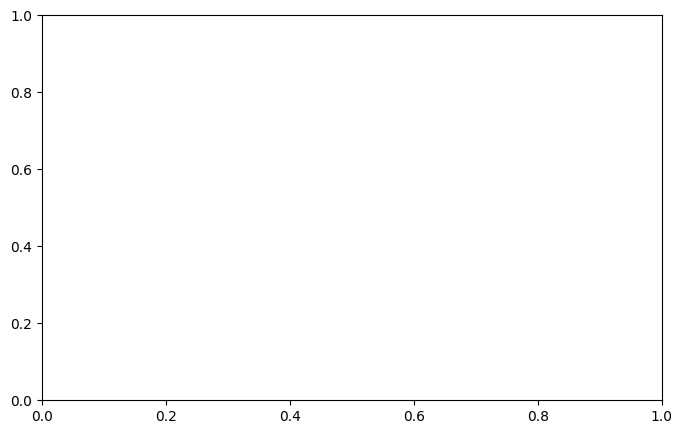

In [44]:
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time

# Set up interactive plot
plt.ion()
fig, ax = plt.subplots(figsize=(8, 5))
train_loss_history = []


In [45]:
next(iter(train_dataloader))

{'input_ids': tensor([[ 101, 6226, 1997,  ...,    0,    0,    0],
         [ 101, 2859, 4247,  ...,    0,    0,    0],
         [ 101, 2028, 2351,  ...,    0,    0,    0],
         ...,
         [ 101, 2720, 1012,  ...,    0,    0,    0],
         [ 101, 2634, 2038,  ...,    0,    0,    0],
         [ 101, 2009, 2435,  ...,    0,    0,    0]]),
 'attn_masks': tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]]),
 'labels': tensor([[-100,    0,    0,  ..., -100, -100, -100],
         [-100,    1,    0,  ..., -100, -100, -100],
         [-100,    0,    0,  ..., -100, -100, -100],
         ...,
         [-100,    4,    4,  ..., -100, -100, -100],
         [-100,    1,    0,  ..., -100, -100, -100],
         [-100,    0,    0,  ..., -100, -100, -100]])}

In [46]:

num_epochs = 1

for epoch in range(num_epochs):
    print(f"\n Epoch {epoch+1}/{num_epochs}")
    print("="*50)
    model.train()
    total_train_loss = 0
    batch_losses = []

    for batch_idx, batch in enumerate(train_dataloader, start=1):
        print(f"Batch {batch_idx}/{len(train_dataloader)}")
        input_ids = batch['input_ids'].to(device)
        attn_masks = batch['attn_masks'].to(device)
        labels = batch['labels'].clone()
        labels[labels == -100] = 0
        labels = labels.to(device)

        optimizer.zero_grad()
        loss = model.loss(input_ids, attn_masks, labels)
        loss.backward()
        optimizer.step()

        batch_loss = loss.item()
        batch_losses.append(batch_loss)
        print(f"Batch loss: {batch_loss:.4f}")

    avg_train_loss = sum(batch_losses) / len(batch_losses)
    train_loss_history.append(avg_train_loss)
    print(f" Train loss: {avg_train_loss:.4f}")

    # === Update plot ===
    clear_output(wait=True)
    ax.clear()
    ax.plot(train_loss_history, label='Train Loss', marker='o')
    ax.set_title("Training Loss Over Epochs")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")
    ax.grid(True)
    ax.legend()
    plt.tight_layout()
    plt.pause(0.1)



<Figure size 640x480 with 0 Axes>

In [ ]:
torch.save(model.state_dict(), "bert_bilstm_crf_model.pt")

In [ ]:
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
}, "checkpoint.pt")

In [ ]:
model.load_state_dict(torch.load("bert_bilstm_crf_model.pt", map_location=device))

In [ ]:
model = BERT_Bi_CRF(bert_model, tagset_size=10).to(device)
model.load_state_dict(torch.load("bert_bilstm_crf_model.pt", map_location=device))



In [50]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch_idx, batch in enumerate(valid_dataloader):
        print(f"Batch {batch_idx}/{len(valid_dataloader)}")
        input_ids = batch['input_ids'].to(device)
        attn_masks = batch['attn_masks'].to(device)
        labels = batch['labels'].clone()

        _, pred_tag_seqs = model(input_ids, attn_masks)

        for i in range(input_ids.size(0)):
            pred_tags = pred_tag_seqs[i]
            true_tags = labels[i].tolist()

            # Filter out special tokens ([CLS], [SEP]) labeled as -100
            filtered_true_tags = []
            for tag in true_tags:
                if tag != -100:
                    filtered_true_tags.append(tag)

            # pred_tags naturally matches the filtered length
            if len(pred_tags) != len(filtered_true_tags):
                print(f"⚠️ Length mismatch in sample {i}")
                print(f"  pred_tags len: {len(pred_tags)}, filtered true_tags len: {len(filtered_true_tags)}")
                break

            all_preds.extend(pred_tags)
            all_labels.extend(filtered_true_tags)

    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='macro')

    print(f" Accuracy: {acc:.4f} | 🏅 F1-score: {f1:.4f}")


Batch 0/119
⚠️ Length mismatch in sample 0
  pred_tags len: 17, filtered true_tags len: 14
Batch 1/119


/home/onyxia/work/.venv/lib/python3.13/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


⚠️ Length mismatch in sample 0
  pred_tags len: 46, filtered true_tags len: 30
Batch 2/119
⚠️ Length mismatch in sample 0
  pred_tags len: 19, filtered true_tags len: 39
Batch 3/119
⚠️ Length mismatch in sample 0
  pred_tags len: 15, filtered true_tags len: 9
Batch 4/119
⚠️ Length mismatch in sample 0
  pred_tags len: 30, filtered true_tags len: 21
Batch 5/119
⚠️ Length mismatch in sample 0
  pred_tags len: 26, filtered true_tags len: 21
Batch 6/119
⚠️ Length mismatch in sample 0
  pred_tags len: 28, filtered true_tags len: 27
Batch 7/119
⚠️ Length mismatch in sample 0
  pred_tags len: 28, filtered true_tags len: 17
Batch 8/119
⚠️ Length mismatch in sample 0
  pred_tags len: 18, filtered true_tags len: 20
Batch 9/119
⚠️ Length mismatch in sample 0
  pred_tags len: 44, filtered true_tags len: 11
Batch 10/119
⚠️ Length mismatch in sample 0
  pred_tags len: 33, filtered true_tags len: 19
Batch 11/119
⚠️ Length mismatch in sample 0
  pred_tags len: 49, filtered true_tags len: 42
Batch 12/1

KeyboardInterrupt: 

In [ ]:
⚠️ Skipping mismatched sample 1
  pred_tags len: 34, true_tags len: 35
⚠️ Skipping mismatched sample 2
  pred_tags len: 16, true_tags len: 44
⚠️ Skipping mismatched sample 3
  pred_tags len: 9, true_tags len: 24
⚠️ Skipping mismatched sample 4
  pred_tags len: 32, true_tags len: 34
⚠️ Skipping mismatched sample 7
  pred_tags len: 24, true_tags len: 32
⚠️ Skipping mismatched sample 9
  pred_tags len: 17, true_tags len: 24
⚠️ Skipping mismatched sample 10
  pred_tags len: 24, true_tags len: 36
⚠️ Skipping mismatched sample 12
  pred_tags len: 35, true_tags len: 42
⚠️ Skipping mismatched sample 13
  pred_tags len: 17, true_tags len: 19
⚠️ Skipping mismatched sample 19
  pred_tags len: 24, true_tags len: 34
⚠️ Skipping mismatched sample 21
  pred_tags len: 20, true_tags len: 22
⚠️ Skipping mismatched sample 25
  pred_tags len: 24, true_tags len: 32
⚠️ Skipping mismatched sample 26

In [ ]:
# length = 60(padded)
labels[1] = tensor([-100,    0,    3,    7,    7,    7,    0,    0,    0,    0,    0,    0,
           0,    0,    1,    5,    0,    0,    0,    0,    0,    2,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0, -100, -100,
        -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
        -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100])
# length = 35
attn_masks[1] = tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
# length = 34
pred_tag_seqs[1] = [np.int64(0), np.int64(0), np.int64(3), np.int64(7), np.int64(3), np.int64(7), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(5), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), 0]
# length = 35
true_tags = [0, 0, 3, 7, 7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 1, 5, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

### Training CRF

### BERT-BiLSTM-CRF

From author: Cao Shuai ,
Licnese : (C)Copyright 2018-2019, MILAB_SCU

Utility functions used in the CRF layer to compute probabilities and decode sequences

In [ ]:
# the vec's shape should be of 2-dimensions
# Return tensor of indices, shape (batch_size,)
def argmax(vec):
  _,idx = torch.max(vec,1)
  return idx.item()


In [ ]:
# compute the highest score from LSTM-layer amongs the tagset, calculate the log-sum exp of the difference between
# the score and the max_score

def log_sum_exp(vec):
  max_score = vec[0,argmax(vec)] # max_score = 5
  max_score_broadcast = max_score.view(1,-1).expand(1,vec.size()[1])
  return max_score + torch.log(torch.sum(torch.exp(vec-max_score_broadcast)))


#### The partition function is the sum of scores for all possible tag sequences, used to normalize probabilities in the CRF.

In [ ]:
#A 3D tensor of shape (batch_size, seq_len, num_tags)
# substract max for stability
# this implements the log partition function
def log_sum_exp_batch(log_tensor, axis=-1):
    """Compute log-sum-exp for a batch of tensors along the specified axis."""
    max_score = torch.max(log_tensor, axis)[0]
    max_score_expanded = max_score.view(log_tensor.shape[0], -1, 1)
    return max_score + torch.log(torch.exp(log_tensor - max_score_expanded).sum(axis))

In [ ]:
# gather : select elements from a tensor using dynamic indices
x = torch.tensor([[1, 2, 3],
                  [4, 5, 6]])

index = torch.tensor([[1,0,2], [2,0,1]])  # Shape: (2, 1)

out = torch.gather(x, dim=1, index=index)  # dim=1 → columns
print(out)


In [ ]:
class Bert_BiLSTM_CRF(nn.Module):
    def __init__(self, bert: BertModel, tag_to_idx: dict, hidden_dim: int = 768):
        """
        Initialize BERT + Bi-LSTM + CRF model for NER.

        Args:
            bert (BertModel): Pretrained BERT model.
            tag_to_idx (dict): Mapping of tags to indices (e.g., {'O': 0, 'B-PER': 1, ...}).
            hidden_dim (int): Hidden dimension of Bi-LSTM (default: 768).
        """
        super(Bert_BiLSTM_CRF, self).__init__()
        self.bert = bert
        self.tag_to_idx = tag_to_idx
        self.tagset_size = len(tag_to_idx)
        self.hidden_dim = hidden_dim
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        # Bi-LSTM: 2 layers, bidirectional, input size = BERT hidden size (768)
        self.lstm = nn.LSTM(
            input_size=768,
            hidden_size=hidden_dim // 2,
            num_layers=2,
            bidirectional=True,
            batch_first=True
        )

        # Linear layer to map LSTM output to tag space
        self.fc = nn.Linear(hidden_dim, self.tagset_size)

        # CRF transition matrix
        self.transitions = nn.Parameter(torch.randn(self.tagset_size, self.tagset_size))

        # Ensure [CLS] and [SEP] are in tag_to_idx
        if '[CLS]' not in tag_to_idx or '[SEP]' not in tag_to_idx:
            raise ValueError("tag_to_idx must include '[CLS]' and '[SEP]'")
        self.start_label_id = tag_to_idx['[CLS]']
        self.end_label_id = tag_to_idx['[SEP]']

        # Initialize transition scores: disallow invalid transitions
        self.transitions.data[self.start_label_id, :] = -10000.0
        self.transitions.data[:, self.end_label_id] = -10000.0
        self.to(self.device)

    def init_hidden(self, batch_size: int):
        """Initialize LSTM hidden state."""
        return (
            torch.randn(4, batch_size, self.hidden_dim // 2).to(self.device),  # 4 = 2 layers * 2 directions
            torch.randn(4, batch_size, self.hidden_dim // 2).to(self.device)
        )

    def _bert_enc(self, input_ids: torch.LongTensor, attention_mask: torch.LongTensor):
        """
        Encode inputs using BERT.

        Args:
            input_ids (torch.LongTensor): Shape (batch_size, seq_len)
            attention_mask (torch.LongTensor): Shape (batch_size, seq_len)

        Returns:
            torch.Tensor: Shape (batch_size, seq_len, 768)
        """
        outputs = self.bert(input_ids, attention_mask=attention_mask)
        return outputs.last_hidden_state

    def _get_lstm_features(self, input_ids: torch.LongTensor, attention_mask: torch.LongTensor):
        """Generate emission scores from BERT and Bi-LSTM."""
        embeds = self._bert_enc(input_ids, attention_mask)  # (batch_size, seq_len, 768)
        batch_size = input_ids.size(0)
        hidden = self.init_hidden(batch_size)
        lstm_out, _ = self.lstm(embeds, hidden)  # (batch_size, seq_len, hidden_dim)
        lstm_feats = self.fc(lstm_out)  # (batch_size, seq_len, tagset_size)
        return lstm_feats

    def _forward_alg(self, feats: torch.Tensor):
        """
        Forward algorithm to compute log partition function (log Z(x)).

        Args:
            feats (torch.Tensor): Emission scores, shape (batch_size, seq_len, tagset_size)

        Returns:
            torch.Tensor: Log partition function, shape (batch_size, 1)
        """
        T = feats.shape[1]
        batch_size = feats.shape[0]

        log_alpha = torch.full((batch_size, 1, self.tagset_size), -10000.0, device=self.device)
        log_alpha[:, 0, self.start_label_id] = 0.0

        for t in range(1, T):
            log_alpha = (log_sum_exp_batch(self.transitions + log_alpha, axis=-1) + feats[:, t]).unsqueeze(1)

        return log_sum_exp_batch(log_alpha)

    def _score_sentence(self, feats: torch.Tensor, label_ids: torch.LongTensor):
        """
        Compute score of given tag sequence.

        Args:
            feats (torch.Tensor): Emission scores, shape (batch_size, seq_len, tagset_size)
            label_ids (torch.LongTensor): True tag indices, shape (batch_size, seq_len)

        Returns:
            torch.Tensor: Score of tag sequence, shape (batch_size, 1)
        """
        T = feats.shape[1]
        batch_size = feats.shape[0]
        score = torch.zeros((batch_size, 1), device=self.device)

        for t in range(1, T):
            mask = (label_ids[:, t] != -100) & (label_ids[:, t-1] != -100)
            score[mask] = score[mask] + \
                self.transitions[label_ids[mask, t-1], label_ids[mask, t]].view(-1, 1) + \
                feats[mask, t].gather(-1, label_ids[mask, t].view(-1, 1))

        return score

    def _viterbi_decode(self, feats: torch.Tensor):
        """
        Viterbi algorithm to find the most likely tag sequence.

        Args:
            feats (torch.Tensor): Emission scores, shape (batch_size, seq_len, tagset_size)

        Returns:
            tuple: (max_logLL, path)
                - max_logLL: Log probability of best sequence, shape (batch_size,)
                - path: Best tag sequence, shape (batch_size, seq_len)
        """
        T = feats.shape[1]
        batch_size = feats.shape[0]

        log_delta = torch.full((batch_size, 1, self.tagset_size), -10000.0, device=self.device)
        log_delta[:, 0, self.start_label_id] = 0.0
        psi = torch.zeros((batch_size, T, self.tagset_size), dtype=torch.long, device=self.device)

        for t in range(1, T):
            log_delta, psi[:, t] = torch.max(self.transitions + log_delta, -1)
            log_delta = (log_delta + feats[:, t]).unsqueeze(1)

        path = torch.zeros((batch_size, T), dtype=torch.long, device=self.device)
        max_logLL, path[:, -1] = torch.max(log_delta.squeeze(), -1)

        for t in range(T-2, -1, -1):
            path[:, t] = psi[:, t+1].gather(-1, path[:, t+1].view(-1, 1)).squeeze()

        return max_logLL, path

    def neg_log_likelihood(self, input_ids: torch.LongTensor, attention_mask: torch.LongTensor, labels: torch.LongTensor):
        """
        Compute negative log-likelihood loss.

        Args:
            input_ids (torch.LongTensor): Shape (batch_size, seq_len)
            attention_mask (torch.LongTensor): Shape (batch_size, seq_len)
            labels (torch.LongTensor): Shape (batch_size, seq_len)

        Returns:
            torch.Tensor: Mean loss across batch
        """
        feats = self._get_lstm_features(input_ids, attention_mask)
        forward_score = self._forward_alg(feats)
        gold_score = self._score_sentence(feats, labels)
        return torch.mean(forward_score - gold_score)

    def forward(self, input_ids: torch.LongTensor, attention_mask: torch.LongTensor, labels: torch.LongTensor = None):
        """
        Forward pass for training or inference.

        Args:
            input_ids (torch.LongTensor): Shape (batch_size, seq_len)
            attention_mask (torch.LongTensor): Shape (batch_size, seq_len)
            labels (torch.LongTensor, optional): Shape (batch_size, seq_len)

        Returns:
            dict: {'loss': torch.Tensor} for training, {'score': torch.Tensor, 'tag_seq': torch.Tensor} for inference
        """
        feats = self._get_lstm_features(input_ids, attention_mask)
        if labels is not None:
            loss = self.neg_log_likelihood(input_ids, attention_mask, labels)
            return {"loss": loss, "logits": feats}
        score, tag_seq = self._viterbi_decode(feats)
        return {"score": score, "tag_seq": tag_seq}


In [ ]:
label2id

In [ ]:
id2label

In [ ]:
mo = BiLSTM_CRF_Tagger_BERT(bert_model,label2id,hidden_dim= 128, num_layers = 2)


In [ ]:
from transformers import get_linear_schedule_with_warmup

In [ ]:
device

In [ ]:
# Example usage with your DataLoader
TRAIN_BATCH_SIZE = 16
VALID_BATCH_SIZE = 16
TEST_BATCH_SIZE = 16

train_params = {
    'batch_size': TRAIN_BATCH_SIZE,
    'shuffle': True
}
valid_params = {
    'batch_size': VALID_BATCH_SIZE,
    'shuffle': False
}
test_params = {
    'batch_size': TEST_BATCH_SIZE,
    'shuffle': False
}



In [ ]:
train_dataset[:2]

In [ ]:
from transformers import BertModel
bert = build_bert_model()

model = Bert_BiLSTM_CRF(bert, label2id)

In [ ]:
bert.config

In [ ]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
num_training_steps = len(train_dataloader) * 3  # 3 epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=int(0.1 * num_training_steps),
    num_training_steps=num_training_steps
)

In [ ]:
train_df.shape

In [ ]:
len(train_dataloader)*16

In [ ]:
for epoch in range(3):
    model.train()
    total_loss = 0
    for index, batch in enumerate(train_dataloader):
        if index % 40 == 0:
          print(f"Batch{index+1} out of {len(train_dataloader)}")
        input_ids = batch['input_ids'].to(device)
        attn_masks = batch['attn_masks'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attn_masks, labels=labels)
        loss = outputs['loss']
        total_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
    loss_avg = total_loss/len(train_dataloader)

    print(f"Epoch {epoch + 1}, Loss: {loss_avg:.4f}")

### Vertibi
#### Purpose
This function implements the Viterbi algorithm to find the most likely tag sequence ($ \arg\max P(y|x) $) for a batch of sequences, given emission scores (feats).

### EarlyStopping

In [ ]:
class EarlyStopping:
    def __init__(self,epoch_limit = 5, improv_threshold = 0):
        self.epoch_limit = epoch_limit
        self.improv_threshold = improv_threshold  #minimum change
        self.best_score = None
        self.early_stop = False
        self.counter = 0
        self.best_model_state = None
    # create our own callable to facilitate configuration
    def __call__(self, val_loss, model):
        score = val_loss
        if self.best_score is None:
            self.best_score = score
            self.best_model_state = model.state_dict()  #keep track of the model state (parameters(weights and biases))
        elif score > self.best_score + self.improv_threshold:
            self.counter += 1
            if self.counter >= self.epoch_limit:
                self.early_stop = True
        else:
            self.best_score = score
            self.best_model_state = model.state_dict()
            self.counter = 0  # reset counter to zero

    def load_best_model(self, model):
        model.load_state_dict(self.best_model_state)


In [ ]:

def train_loop_bilstm(model, train_dataloader, optimizer, scheduler, epochs,
                      device=torch.device('cpu'), seed_val=42, tagset_size=None):
    random.seed(seed_val)
    np.random.seed(seed_val)
    torch.manual_seed(seed_val)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed_val)

    # Move model to device
    model.to(device)
    best_model_state = copy.deepcopy(model.state_dict())
    min_train_loss = float('inf')
    loss_values_train = []
    loss_values_valid = []

    # Define loss function (already included in model, but kept here for clarity)
    loss_fn = nn.CrossEntropyLoss(ignore_index=-100)

    for epoch_i in range(epochs):
        print(f'======== Epoch {epoch_i + 1} / {epochs} ========')
        print('Training...')
        total_loss = 0.0
        model.train()

        for step, batch in enumerate(train_dataloader):
            if step % 40 == 0 and step != 0:
                print(f'  Batch {step} of {len(train_dataloader)}')

            # Get inputs from NerDataset_BERT
            input_ids = batch['input_ids'].to(device)  # Shape: (B, S)
            attn_masks = batch['attn_masks'].to(device)  # Shape: (B, S)
            labels = batch['labels'].to(device)  # Shape: (B, S)

            # Compute actual lengths from attention_mask
            lengths = attn_masks.sum(dim=-1).to('cpu')  # Number of non-padded tokens per sequence

            model.zero_grad()

            #forward pass (using revised BiLSTMTagger_BERT)
            outputs = model(input_ids, attention_mask=attn_masks, lengths=lengths, labels=labels)
            loss = outputs['loss']  # Loss is computed in the model's forward method


            total_loss += loss.item()
            loss.backward()

            # Clip gradients to prevent exploding gradients
            # this keeps the direction of gradient while clipping the gradient to be between (-1,1)
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) # we may use batch normalization, but it is more complicated in RNN
            optimizer.step() # update parameter
            scheduler.step() # update learning rate to have suitable early training and late training


        avg_train_loss = total_loss / len(train_dataloader)
        loss_values_train.append(avg_train_loss)


        model.eval()
        with torch.inference_mode():
          for step, batch in enumerate(valid_dataloader):
            input_ids = batch["input_ids"].to(device)
            attn_masks = batch["attn_masks"].to(device)
            labels = batch["labels"].to(device)
            lengths = attn_masks.sum(dim = -1).to('cpu')
            predict = model(input_ids, attn_masks,lengths, labels)
            valid_loss = outputs["loss"]
            total_valid_loss += valid_loss.item()
          avg_valid_loss = total_valid_loss/len(valid_dataloader)
        loss_values_valid.append(avg_valid_loss)
        early_stopping(valid_loss_avg, model)
        if early_stopping.early_stop:
          print("Early stopping")
          best_model_state = early_stopping.best_model_state(model)
          break

        print(f"  Average training loss: {avg_train_loss:.4f}, Average validation loss: {avg_valid_loss: .4f}")

    # Load best model state
    model.load_state_dict(best_model_state)
    return loss_values_valid,  model

In [ ]:
from torch.utils.data import DataLoader
from torch.optim import AdamW
from torch.optim.lr_scheduler import StepLR

#initialize model and dataloader
model = BiLSTMTagger_BERT(bert_model,tagset_size=TAGSET_SIZE)
#optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
scheduler = StepLR(optimizer, step_size=1, gamma=0.1)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [ ]:

#train
loss_valid_values,best_model = train_loop_bilstm(
    model=model,
    train_dataloader=train_dataloader,
    optimizer=optimizer,
    scheduler=scheduler,
    epochs=2,
    device=device,
    seed_val=42,
    tagset_size=TAGSET_SIZE
)

print("Training complete. Loss values:", loss_valid_values)


In [ ]:
torch.save(model.state_dict, "BiLSTM_PT_Soft_BERT")

### Optimizer - AdamW:

AdamW is a stochastic optimization method that modifies the typical implementation of weight decay in Adam, by decoupling weight decay from the gradient update.

Learning Rate:

Learning rate is a tuning parameter in machine learning and statistics that controls how much a model's parameters adjust during each iteration of an optimization algorithm. It's a floating point number that's usually between 0.01 and 0.1

Adam Epsilon:

The parameter epsilon shows up in the update step.

θ_t <- θ_{t-1} - α • mhat_t / (sqrt(vhat_t) + ε)

It is primarily used as a guard against a zero second second moment causing a division by zero case. If it is too large it will bias the moment estimation.

In [ ]:
def eval_fn(model, test_dataloader):
    # put model in evaluation mode
    model.eval()

    eval_loss, eval_accuracy = 0, 0
    nb_eval_examples, nb_eval_steps = 0, 0
    eval_preds, eval_labels = [], []

    with torch.no_grad():
        for idx, batch in enumerate(test_dataloader):

            ids = batch['input_ids'].to(device, dtype = torch.long)
            mask = batch['attn_masks'].to(device, dtype = torch.long)
            targets = batch['labels'].to(device, dtype = torch.long)

            outputs = model(input_ids=ids, attention_mask=mask, labels=targets)
            loss, eval_logits = outputs.loss, outputs.logits

            eval_loss += loss.item()

            nb_eval_steps += 1
            nb_eval_examples += targets.size(0)

            if idx % 40==0:
                loss_step = eval_loss/nb_eval_steps
                print(f"Validation loss per 100 evaluation steps: {loss_step}")

            # compute evaluation accuracy
            flattened_targets = targets.view(-1) # shape (batch_size * seq_len,)
            active_logits = eval_logits.view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
            flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size * seq_len,)

            # now, use mask to determine where we should compare predictions with
            # targets (includes [CLS] and [SEP] token predictions)
            active_accuracy = mask.view(-1) == 1 # active accuracy is also of shape (batch_size * seq_len,)

            # actual targets
            targets = torch.masked_select(flattened_targets, active_accuracy).cpu().numpy()
            # actual preicted labels
            predictions = torch.masked_select(flattened_predictions, active_accuracy).cpu().numpy()


            real_tar_ = []
            real_pred_ = []

            for t,p in zip(targets, predictions):
                if t != -100:
                    real_tar_.append(t)
                    real_pred_.append(p)

            eval_labels.extend(real_tar_)
            eval_preds.extend(real_pred_)

            tmp_eval_accuracy = accuracy_score(real_tar_, real_pred_)
            eval_accuracy += tmp_eval_accuracy


    eval_loss = eval_loss / nb_eval_steps
    eval_accuracy = eval_accuracy / nb_eval_steps
    print(f"Validation Loss: {eval_loss}")
    print(f"Validation Accuracy: {eval_accuracy}")

    return eval_labels, eval_preds

In [ ]:
true_labels, pred_labels = eval_fn(best_model, valid_dataloader)

In [ ]:
def print_full_classification_report(true_labels, pred_labels, zero_division=np.nan):
    # computing the accuracy
    accuracy = accuracy_score(y_true=true_labels, y_pred=pred_labels, )

    print("\naccuracy score {:.3%}".format(accuracy))

    # compute the macro precision
    macro_precision = precision_score(y_true=true_labels, y_pred=pred_labels, average='macro',
                                      zero_division=zero_division)
    # compute the macro recall
    macro_recall = recall_score(y_true=true_labels, y_pred=pred_labels, average='macro',)
    # compute the macro f1_score
    macro_f1_score = f1_score(y_true = true_labels, y_pred = pred_labels, average='macro')

    print("\n----- macro scores --------")
    print("macro precision score: {:.3%}".format(macro_precision))
    print("macro recall score: {:.3%}".format(macro_recall))
    print("macro f1 score: {:.3%}".format(macro_f1_score))

    # ---- micro scores -------
    micro_precision = precision_score(y_true=true_labels, y_pred=pred_labels, average='micro',
                                      zero_division=zero_division)

    micro_recall = recall_score(y_true=true_labels, y_pred=pred_labels, average='micro')

    micro_f1_score = f1_score(y_true = true_labels, y_pred = pred_labels, average='micro')


    print("\n----- micro scores --------")
    print("micro precision score: {:.2%}".format(micro_precision))
    print("micro recall score: {:.2%}".format(micro_recall))
    print("micro f1 score: {:.2%}".format(micro_f1_score))

    # ------ weighted scores------
    wt_precision = precision_score(y_true=true_labels, y_pred=pred_labels, average='weighted',
                                             zero_division=zero_division)

    wt_recall = recall_score(y_true=true_labels, y_pred=pred_labels, average='weighted')

    wt_f1_score = f1_score(y_true = true_labels, y_pred = pred_labels, average='weighted')

    print("\n----- weighted scores --------")
    print("weighted precision score: {:.2%}".format(wt_precision))
    print("weighted recall score: {:.2%}".format(wt_recall))
    print("weighted f1 score: {:.2%}".format(wt_f1_score))

In [ ]:
print("\nEvaluation Metrics for Validation DataSet")
print("=========================================")
print_full_classification_report(true_labels, pred_labels)

In [ ]:
from sklearn.metrics import classification_report

clf_report_for_valid = classification_report(y_true=true_labels,
                                             y_pred=pred_labels,
                                             labels=[x for x in range(len(label2id))],
                                             target_names=list(label2id.keys()),
                                             zero_division=0
                                            )
print("\nLabel-Wise Evaluation Metrics for Validation DataSet")
print("Classification Report for each label\n")
print(clf_report_for_valid)

In [ ]:
label_names_ = list(label2id.keys())
label_ids_ = [i for i in range(len(label_names_))]

# compute confusion matrix collectively
cm_for_valid = confusion_matrix(y_true=true_labels,
                                y_pred=pred_labels,
                                labels=label_ids_,
                               )

# compute NORMALIZE (row) confusion matrix collectively
cm_for_valid_norm = confusion_matrix(y_true=true_labels,
                                y_pred=pred_labels,
                                labels=label_ids_,
                                normalize='true'
                               )

df_cm_for_valid = pd.DataFrame(cm_for_valid, index=label_names_, columns=label_names_)
df_cm_for_valid_norm = pd.DataFrame(cm_for_valid_norm, index=label_names_, columns=label_names_)

print("Confusion Matrix DataFrame")
display(df_cm_for_valid)

In [ ]:
# compute multilabel confusion matrix
# Here it will compute cm at the class level
# labels are binarized under a one-vs-rest way
mcm_for_valid = multilabel_confusion_matrix(y_true=true_labels,
                                        y_pred=pred_labels,
                                        labels=label_ids_,
                                       )

# Label wise confusin matrix (one vs all fashion)
for label_, l_cm in zip(label_names_, mcm_for_valid):
    col_names_ = [f"not_{label_}",label_]
    print(f"Validation Dataset - Confusion Matrix for {label_}")
    ldf = pd.DataFrame(l_cm, index=col_names_, columns=col_names_)
    display(ldf)
    print("-----------------------------\n")

In [ ]:
def create_input_ids(sentence, tokenizer):
    """
    Create sample input ids for a given sentence using the tokenizer
    """
    # Encoding and convert the sentences into tensors
    sample_sentence = tokenizer.encode(' '.join(sentence))
    sample_input_ids = torch.tensor([sample_sentence])

    return sample_input_ids

In [ ]:
from torch import nn

def make_raw_prediction(sentence, model, tokenizer, unseen_word_label='O', device='cpu'):
    # Function which retrieves key value for our Label Dictionary
    def get_key(val):
        for key, value in label2id.items():
             if val == value:
                 return key
        return unseen_word_label

    try:
        device = torch.device(device)
    except:
        print(f"unable to move to device {device}. Hence using cpu.")
        device = torch.device('cpu')

    # move model to device
    model.to(device)
    # Create sample input ids
    sample_input_ids = create_input_ids(sentence, tokenizer)
    # move the input ids to device
    sample_input_ids.to(device)
    # Predicting the test sample using model() function
    with torch.no_grad():
        output = model(sample_input_ids)

    # Extract the labels
    label_indices = np.argmax(output[0].to('cpu').numpy(), axis=2)
    #Tokenize
    tokens = tokenizer.convert_ids_to_tokens(sample_input_ids.to('cpu').numpy()[0])

    # We need to club wordpieces starting with "##' in a single word
    new_tokens, new_label = [], []
    for token, label_idx in zip(tokens, label_indices[0]):
        if token.startswith("##"):
            new_tokens[-1] = new_tokens[-1] + token[2:]
        else:
            new_label.append(get_key(label_idx))
            new_tokens.append(token)

    #Appending Tokens and Labels
    sample_token, sample_label = [], []
    for token, label in zip(new_tokens, new_label):
        sample_token.append(token)
        sample_label.append(label)

    return sample_token, sample_label

In [ ]:
def preprocess_raw_prediction(test_sentence, sample_token, sample_label):
    # remove special tokens and corresponding labels
    # they are not required
    filter_tokens = sample_token[1:-1]
    filter_labels = sample_label[1:-1]

    # Result stored in list as token, label pair
    res = []
    # initial index for list of sample tokens
    tok_idx = 0

    # iterate through each token of test sentence
    for word in test_sentence:
        # pair to store the current word and its label
        pair = tuple()
        # check the length of current word
        word_len = len(word)
        # check the length of current token in sample tokens
        tok_len = len(filter_tokens[tok_idx])

        # Note: We are using the strategy that will
        # assume that 1st word piece label is the
        # label for the entire word.
        # Hence, get the label for current token
        tok_labl =  filter_labels[tok_idx]

        # update the pair
        pair = (word, tok_labl)

        # increment the idx till word_len becomes equal to tok len
        while word_len > tok_len:
            # increment token idex
            tok_idx +=1
            # add the length of next token
            tok_len += len(filter_tokens[tok_idx])
        tok_idx+=1
        res.append(pair)
    return res

In [ ]:
def make_prediction(sentence, model, tokenizer, unseen_word_label='O', sent_delimiter=" ", device='cpu'):

    # check if sentence is a list of words
    if isinstance(sentence, str):
        # create the string
        sentence = sentence.strip().split(sent_delimiter)

    # compute raw predictions
    sample_token, sample_label = make_raw_prediction(sentence, model, tokenizer, unseen_word_label, device)

    # preprocess raw prediction to make clean predictions
    clean_pred_ = preprocess_raw_prediction(sentence, sample_token, sample_label)

    return clean_pred_

In [ ]:
sent_ = input("Enter any sentence:")

In [ ]:
print(f"The sentence entered is:\n {sent_}")

# compute label predictions
pred_labels_ = make_prediction(sent_, model=best_model, tokenizer=tokenizer, device='cpu')

In [ ]:
pred_df_ = pd.DataFrame(data=pred_labels_, columns=['Token', 'Labels'])
pred_df_.T

In [ ]:
# Tokenize sentences (whitespace)
def tokenize(sentence):
    return sentence.strip().split()
# Split labels
def split_labels(label_str):
    return label_str.strip().split(',')


In [ ]:

train_df['tokens'] = train_df['sentence'].apply(tokenize)
train_df['label_list'] = train_df['labels'].apply(split_labels)

In [ ]:
train_df[train_df["tokens"].apply(len) >50]



### ID tokenization

### We can use Text vectorization

# Text vectorization consiste of parts:
<li>
    Standardization
</li>
<li>
    Tokenization
</li>
<li>
    Vocabulary building
</li>

### Vocabulary

### Necessary dictionaries for encoding and decoding phase

In [ ]:

label2id = {k:v+1 for v,k in enumerate(all_labels)}
id2label = {k+1:v for k,v in enumerate(all_labels)}

In [ ]:
label2id["<PAD>"] = 0

In [ ]:
label2id

In [ ]:
word_counts = Counter(word for tokens in train_df['tokens'] for word in tokens)
word2id = {word: i + 2 for i, word in enumerate(word_counts)} # turn words into unique ids (+2) because give 0,1 to UNK and PAD

In [ ]:
id2word = {i+2:word for i,word in enumerate(word_counts)}


### Add '<PAD>' to use when padding and '<UNK>' in the case where there are unknown entities

In [ ]:
word2id['<PAD>'] = 0
word2id['<UNK>'] = 1

In [ ]:
fallback = '<UNK>'
fallback_id = word2id.get('B-gpe', list(label2id.values())[0])  ## get idea of a word

fallback_id

In [ ]:
pad_token = '<PAD>'
pad_id = label2id.get(pad_token, list(label2id.values())[0])
pad_id

In [ ]:
MAX_LEN = 40

def encode(tokens, vocab, pad_len=40, fallback='<UNK>', pad_token='<PAD>'):
    """
    Encodes a list of tokens using a vocabulary.

    - tokens: List[str] → tokens or labels (e.g., words or NER tags)
    - vocab: dict → maps token to index
    - pad_len: int → fixed output length (pad or truncate)
    - fallback: str → token to use if one isn't found (only relevant for input)
    - pad_token: str → token to use for padding

    Returns: List[int] of length `pad_len`
    """
    fallback_id = vocab.get(fallback, 0)     # Use <UNK> if token not found
    pad_id = vocab.get(pad_token, 0)         # Use <PAD> for padding

    # Map each token to its ID
    ids = [vocab.get(tok, fallback_id) for tok in tokens]

    # Truncate or pad to fixed length
    if len(ids) > pad_len:
        return ids[:pad_len]
    else:
        return ids + [pad_id] * (pad_len - len(ids))


In [ ]:
X = np.array([encode(tokens, word2id, fallback='<UNK>', pad_token='<PAD>') for tokens in train_df['tokens']])
y = np.array([encode(labels, label2id, fallback='O', pad_token= '<PAD>') for labels in train_df['label_list']])
vocab_size = len(word2id)
label_size = len(label2id)


In [ ]:
X[0]

In [ ]:
## Example:
sentence = train_df['tokens'][2]
label    = train_df['label_list'][2]
encoded_sentence = encode(sentence,word2id,fallback= '<UNK>', pad_token = '<PAD>')
encoded_label  = encode(label, label2id, fallback = 'O', pad_token = '<PAD>')
print(f"Sentence : {sentence} with length {len(sentence)}\n",
       f"encoded sentence : {encoded_sentence} with length {len(encoded_sentence)}\n")

print(f"Label : {label} with length {len(label)}\n",
       f"encoded label : {encoded_label} with length {len(encoded_label)}")

In [ ]:

id2word = {v:k for k,v in word2id.items()}
# Decode the sentence
decoded_sentence = [id2word.get(word_id, '<UNK>') for word_id in encoded_sentence]
decoded_sentence

In [ ]:
## Convert to sentence with masked entity
sentence_masked = []
for index, lab in enumerate(label):
    if lab == 'O':
        sentence_masked.append(sentence[index])
    else:
        sentence_masked.append(label[index])
sentence_masked

In [ ]:
print(f"X shape: {X.shape}, y shape: {y.shape}")

In [ ]:
vocab_size,label_size

In [ ]:
valid_df

In [ ]:
import matplotlib.pyplot as plt

# Plotting the loss curves
plt.figure(figsize=(10, 5))
plt.plot(loss_train, label='Training Loss')
plt.plot(loss_valid, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting the accuracy curves
plt.figure(figsize=(10, 5))
plt.plot(acc_train, label='Training Accuracy')
plt.plot(acc_valid, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plotting the F1-score curve
plt.figure(figsize=(10, 5))
plt.plot(f1_valid, label='Validation F1-score')
plt.title('Validation F1-score')
plt.xlabel('Epochs')
plt.ylabel('F1-score')
plt.legend()
plt.show()

In [ ]:
def eval_fn(model, test_dataloader):
    # put model in evaluation mode
    model.eval()

    eval_loss, eval_accuracy = 0, 0
    nb_eval_examples, nb_eval_steps = 0, 0
    eval_preds, eval_labels = [], []

    with torch.no_grad():
        for idx, batch in enumerate(test_dataloader):

            ids = batch['input_ids'].to(device, dtype = torch.long)
            mask = batch['attn_masks'].to(device, dtype = torch.long)
            targets = batch['labels'].to(device, dtype = torch.long)

            outputs = model(input_ids=ids, attention_mask=mask, labels=targets)
            loss, eval_logits = outputs.loss, outputs.logits

            eval_loss += loss.item()

            nb_eval_steps += 1
            nb_eval_examples += targets.size(0)

            if idx % 40==0:
                loss_step = eval_loss/nb_eval_steps
                print(f"Validation loss per 100 evaluation steps: {loss_step}")

            # compute evaluation accuracy
            flattened_targets = targets.view(-1) # shape (batch_size * seq_len,)
            active_logits = eval_logits.view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
            flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size * seq_len,)

            # now, use mask to determine where we should compare predictions with
            # targets (includes [CLS] and [SEP] token predictions)
            active_accuracy = mask.view(-1) == 1 # active accuracy is also of shape (batch_size * seq_len,)

            # actual targets
            targets = torch.masked_select(flattened_targets, active_accuracy).cpu().numpy()
            # actual preicted labels
            predictions = torch.masked_select(flattened_predictions, active_accuracy).cpu().numpy()


            real_tar_ = []
            real_pred_ = []

            for t,p in zip(targets, predictions):
                if t != -100:
                    real_tar_.append(t)
                    real_pred_.append(p)

            eval_labels.extend(real_tar_)
            eval_preds.extend(real_pred_)

            tmp_eval_accuracy = accuracy_score(real_tar_, real_pred_)
            eval_accuracy += tmp_eval_accuracy


    eval_loss = eval_loss / nb_eval_steps
    eval_accuracy = eval_accuracy / nb_eval_steps
    print(f"Validation Loss: {eval_loss}")
    print(f"Validation Accuracy: {eval_accuracy}")

    return eval_labels, eval_preds
# Evaluate the model on the test set
true_labels, pred_labels = eval_fn(trained_model, test_dataloader)

# Print the classification report
print("\nEvaluation Metrics for Test DataSet")
print("=========================================")
print_full_classification_report(true_labels, pred_labels)

# Print the label-wise classification report
clf_report_for_test = classification_report(y_true=true_labels,
                                             y_pred=pred_labels,
                                             labels=[x for x in range(len(label2id))],
                                             target_names=list(label2id.keys()),
                                             zero_division=0
                                            )
print("\nLabel-Wise Evaluation Metrics for Test DataSet")
print("Classification Report for each label\n")
print(clf_report_for_test)